
# Project: Investigate a Dataset - TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

As mentioned in the [Choosing a Dataset](Choosing%20a%20Dataset.ipynb) notebook, I've chosen the [TMDb movie data](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata) dataset. The data is pretty clean already, so there won't be much to do in terms of data hygiene, but there are quite a lot of questions we can ask regarding the data, and some of them will require us to tweak the data slightly (splitting by actors, or directors, for instance).

I couldn't find much in terms of detailed documentation regarding the dataset (other than the one provided in the project's page), so I had to make assumptions about most of the column contents. The following table summarizes each column:

| Column               | Type  | Description |
|:---------------------|:-----:|:------------|
| id                   | int   | TMDb id     |
| imdb_id              | str   | IMDb id     |
| popularity           | float | TMDb popularity [score](https://developers.themoviedb.org/3/getting-started/popularity) |
| budget               | int   | Budget in USD |
| revenue              | int   | Revenue in USD |
| original_title       | str   | Original title |
| cast                 | str   | Pipe separated list of cast members |
| homepage             | str   | URL of the movie's homepage |
| director             | str   | Pipe separated list of directors |
| tagline              | str   | Movie tag line |
| keywords             | str   | Keywords associated with the movie |
| overview             | str   | Overview of the movie |
| runtime              | int   | Runtime in minutes |
| genres               | str   | Pipe separated list of genres |
| production_companies | str   | Pipe separated list of production companies involved |
| release_date         | str   | Release date |
| vote_count           | int   | Number of votes |
| vote_average         | float | Vote average |
| budget_adj           | float | Budget adjusted to 2010 |
| revenue_adj          | float | Revenue adjusted to 2010 |

Although budget and revenue can be analyzed using the 2010 adjusted values, when presenting information regarding monitary values, it's usual to adjust those to the time reference of when the analysis was presented, so the readers have clearer picture of the amounts involved. Because of this I've decided to provide 2021 inflation adjusted values.

I could have used Python's [cpi](https://pypi.org/project/cpi/) module to easily compute the adjustment, but I chose to use the [Inflation, consumer prices (annual %)](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG) indicator from the World Bank, combined with the formula described in this [blog post](https://www.sapling.com/5104646/calculate-inflation-adjustment).

The following metadata (comes with the dataset) describes the indicator:

|INDICATOR_CODE|INDICATOR_NAME|SOURCE_NOTE|
|:-------------|:------------:|:----------|
|FP.CPI.TOTL.ZG|Inflation, consumer prices (annual %)|Inflation as measured by the consumer price index reflects the annual percentage change in the cost to the average consumer of acquiring a basket of goods and services that may be fixed or changed at specified intervals, such as yearly. The Laspeyres formula is generally used.|

The data itself is structured as follows:

| Column       | Type | Description |
|:-------------|:----:|:------------|
|Country Name  |string|Name of the country|
|Country Code  |string|ISO Code of the country|
|Indicator Name|string|Fixed value: ``"Inflation, consumer prices (annual %)"``|
|Indicator Code|string|Fixed value: ``"FP.CPI.TOTL.ZG"``|
|1960...2021   |float |Indicator value for the year column|

In order to use this data, I'll have to filter, transpose and clean the table to produce a usable ``DataFrame``.

### Question(s) for Analysis

* Which genres are most popular from year to year? (taken from the [Investigate a Dataset - Data Set Options](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub))
* What kinds of properties are associated with movies that have high revenues? (taken from the [Investigate a Dataset - Data Set Options](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub))
* Is there a specific month of the year were the highest grossing films released? Is this consistent across genres?
* Of the top 5 most prolific directors, which one had the most consistently highly rated films?

In [1]:
import urllib.request

from pathlib import Path
from zipfile import ZipFile

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
# !pip install --upgrade pandas==0.25.0 (commented out as the requirements' pandas version is already newer)

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Since I wanted to make this notebook as portable as possible, instead of relying on the local filesystem to load the data, I'm going to fetch it straight from the source. I'll use ``pandas``' feature that allows me to pass a URL to most ``read_*`` functions, or I'll Python's ``urllib.request`` to fetch the packages that need pre-processing before being ingested by ``pandas``.

First we fetch the *TMDb movie data* dataset straight from the URL mentioned in the [Investigate a Dataset - Data Set Options](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub) page. Depending on the speed of your connection, the following cell might take a little while to evaluate.

In [3]:
tmdb_movie_data_df = pd.read_csv(
    "https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv"
)

In [4]:
tmdb_movie_data_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [5]:
tmdb_movie_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

As we can see, all the expected columns are present and accounted for. We also need to check the Python types of the columns.

In [6]:
for column, value in tmdb_movie_data_df[~tmdb_movie_data_df.isna()].iloc[0, :].to_dict().items():
    print(f"{column}: {type(value)}")

id: <class 'int'>
imdb_id: <class 'str'>
popularity: <class 'float'>
budget: <class 'int'>
revenue: <class 'int'>
original_title: <class 'str'>
cast: <class 'str'>
homepage: <class 'str'>
director: <class 'str'>
tagline: <class 'str'>
keywords: <class 'str'>
overview: <class 'str'>
runtime: <class 'int'>
genres: <class 'str'>
production_companies: <class 'str'>
release_date: <class 'str'>
vote_count: <class 'int'>
vote_average: <class 'float'>
release_year: <class 'int'>
budget_adj: <class 'float'>
revenue_adj: <class 'float'>


As you can see, the ``release_date`` field is a string, so we will need to convert it to ``datetime`` so we can project on the components of the date. The rest of the fields do not require special attention, with the exception of those that contain pipe separated lists of values, but those will be handled when the need arises.

As I mentioned in the introduction I want to adjust the ``budget`` and ``revenue`` values according to inflation using [this formula](https://www.sapling.com/5104646/calculate-inflation-adjustment). In order to do that, I'm going to fetch the ["Inflation, consumer prices (annual %)"](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG) indicator dataset straight from the world bank website.

Even though the data is in CSV format, it is packaged on a zip file, so I need to extract the contents before I can pass it to ``pandas``' ``read_csv`` function.

In [7]:
fp_cpi_totl_zg_zip_path = Path("fp_cpi_totl_zg.zip")

In [8]:
urllib.request.urlretrieve(
    "https://api.worldbank.org/v2/en/indicator/FP.CPI.TOTL.ZG?downloadformat=csv",
    fp_cpi_totl_zg_zip_path
);

First, let's list the contents for the file:

In [9]:
with ZipFile(fp_cpi_totl_zg_zip_path) as zf:
    for zi in zf.filelist:
        print(zi.filename)

Metadata_Indicator_API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4330294.csv
API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4330294.csv
Metadata_Country_API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4330294.csv


The file that we're looking for is ``API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4330294.csv``. The other two contain metadata that is irrelevant to the analysis. I can't open and pass this file straight to ``read_csv`` because there are a few informational lines at the beginning:

In [10]:
with ZipFile(fp_cpi_totl_zg_zip_path) as zf:
    with zf.open("API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4330294.csv", "r") as f:
        for i, line in enumerate(f.readlines()[:4], start=1):
            print(f"{i}: {line.decode('utf-8')}")

1: ﻿"Data Source","World Development Indicators",

2: 

3: "Last Updated Date","2022-07-20",

4: 



Luckily, ``read_csv`` has a ``skiprows`` argument that allow us to skip these lines:

In [11]:
with ZipFile(fp_cpi_totl_zg_zip_path) as zf:
    with zf.open("API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4330294.csv") as f:
        fp_cpi_totl_zg_df = pd.read_csv(f, skiprows=4)

In [12]:
fp_cpi_totl_zg_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.750981,5.370290,5.250171,6.571396,6.399343,4.720811,4.120246,5.404815,7.240978,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.439201,1.758052,2.130268,1.494564,1.764635,1.784050,1.758565,2.492522,3.925603,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN,NaN,NaN


In [13]:
fp_cpi_totl_zg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            70 non-null     float64
 5   1961            72 non-null     float64
 6   1962            74 non-null     float64
 7   1963            75 non-null     float64
 8   1964            79 non-null     float64
 9   1965            86 non-null     float64
 10  1966            93 non-null     float64
 11  1967            100 non-null    float64
 12  1968            101 non-null    float64
 13  1969            102 non-null    float64
 14  1970            107 non-null    float64
 15  1971            111 non-null    float64
 16  1972            114 non-null    float64
 17  1973            117 non-null    flo

As I mentioned in the <a href="#intro">Introduction</a>, the dataframe is indexed on the country, with a column for each year. Before I can use this to adjust the monetary values in the ``tmdb_movie_data_df`` dataframe, I'll have to process the inflation dataframe to make it easier to work with, which I'll do in the next section.

### Data Cleaning

Are there any duplicates in the ``tmdb_movie_data_df`` dataframe?

In [14]:
tmdb_movie_data_df.duplicated().sum()

1

In [15]:
tmdb_movie_data_df[tmdb_movie_data_df.duplicated()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2090,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0


Let's get rid of the duplicates:

In [16]:
tmdb_movie_data_df.drop_duplicates(inplace=True)

In [17]:
tmdb_movie_data_df.duplicated().sum()

0

Since I'm focusing on the ``budget``, ``revenue`` both as dependent and independent variables, I need to make sure there's no missing or invalid information.

In [18]:
tmdb_movie_data_df[["budget", "revenue"]].describe()

,budget,revenue
count,1.086500e+04,1.086500e+04
mean,1.462429e+07,3.982690e+07
std,3.091428e+07,1.170083e+08
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.500000e+07,2.400000e+07
max,4.250000e+08,2.781506e+09


There are movies where the ``budget`` or the ``revenue`` is "0", which we'll consider missing information. Let's evaluate the extent of this case:

In [19]:
(tmdb_movie_data_df.budget == 0).sum(), (tmdb_movie_data_df.budget_adj == 0).sum(), tmdb_movie_data_df.shape[0]

(5696, 5696, 10865)

There are quite a lot of movies without budget info, so we can't get rid of them as we would be losing half our dataset. I'll have to filter those out when I want to do any analysis that involves this variable. Let's see what's the situation with the ``revenue``:

In [20]:
(tmdb_movie_data_df.revenue == 0).sum(), (tmdb_movie_data_df.revenue_adj == 0).sum(), tmdb_movie_data_df.shape[0]

(6016, 6016, 10865)

In [21]:
((tmdb_movie_data_df.budget == 0) & (tmdb_movie_data_df.revenue != 0)).sum()

995

So it seems there are are some movies with a ``revenue``value but not a ``budget`` value. I think the safest course of action, given the questions that I've formulated in the previous section, is to drop the rows without a ``revenue`` value, and keep those without a ``budget`` value, and make sure those are filtered out whenever I'm doing an analysis that involves both values.

In [22]:
tmdb_movie_data_df = tmdb_movie_data_df[tmdb_movie_data_df.revenue != 0]

In [23]:
(tmdb_movie_data_df.revenue == 0).sum(), (tmdb_movie_data_df.revenue_adj == 0).sum()

(0, 0)

The next step is to adjust the ``budget`` and ``revenue`` to 2021 USD values. Before we can do that, let's analyise the ``fp_cpi_totl_zg_df`` dataframe:

In [24]:
fp_cpi_totl_zg_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.750981,5.370290,5.250171,6.571396,6.399343,4.720811,4.120246,5.404815,7.240978,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.439201,1.758052,2.130268,1.494564,1.764635,1.784050,1.758565,2.492522,3.925603,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN,NaN,NaN


As you can see, the values are indexed on the country name, with a column for each year. The first thing we need to do is to keep only the values for the US, as (I assume) the budget and revenue values are in US dollars:

In [25]:
inflation_rate_df = fp_cpi_totl_zg_df[fp_cpi_totl_zg_df["Country Code"] == "USA"]

In [26]:
inflation_rate_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
251,United States,USA,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,...,1.464833,1.622223,0.118627,1.261583,2.13011,2.442583,1.81221,1.233584,4.697859,NaN


Now we have just the one row, but we need to drop the redundant columns:

In [27]:
inflation_rate_df = inflation_rate_df.drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis=1)

In [28]:
inflation_rate_df.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
251,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,5.462386,...,1.464833,1.622223,0.118627,1.261583,2.13011,2.442583,1.81221,1.233584,4.697859,NaN


Now, we transpose the dataframe, and rename the columns, to make them easier to work with:

In [29]:
inflation_rate_df = inflation_rate_df\
    .T\
    .rename({251: "inflation_rate"}, axis=1)

In [30]:
inflation_rate_df.head()

,inflation_rate
1960,1.457976
1961,1.070724
1962,1.198773
1963,1.239669
1964,1.278912


Now we check for missing values, and drop them if necessary:

In [31]:
inflation_rate_df.inflation_rate.isna().sum()

1

In [32]:
inflation_rate_df[inflation_rate_df.inflation_rate.isna()]

,inflation_rate
Unnamed: 66,NaN


In [33]:
inflation_rate_df.dropna(inplace=True)

In [34]:
inflation_rate_df.inflation_rate.isna().sum()

0

Since we want my intention is to merge with the ``tmdb_movie_data_df`` dataframe on the ``release_year`` column, we need to convert the index of ``inflation_rate_df`` to ``int``:

In [35]:
inflation_rate_df.index = inflation_rate_df.index.astype(int)

The last step is to compute the adjustment factor for each year. The formula for this transformation is defined in [this blogpost](https://www.sapling.com/5104646/calculate-inflation-adjustment).

In [36]:
inflation_rate_df["adj_factor_2021"] = inflation_rate_df.apply(
    lambda r: ((inflation_rate_df.loc[(inflation_rate_df.index >= r.name) & (inflation_rate_df.index <= 2021)] / 100.0) + 1.0).prod(),
    axis=1
)

In [37]:
inflation_rate_df.head()

,inflation_rate,adj_factor_2021
1960,1.457976,9.295703
1961,1.070724,9.162122
1962,1.198773,9.065060
1963,1.239669,8.957678
1964,1.278912,8.847992


Now to adjust a value to 2021 US dollors, all I need to do is to multiply to the factor associated with the given year.

Now let's add ``budget_adj_2021`` and ``revenue_adj_2021`` columns to the ``tmdb_movie_data_df``. First we merge with ``inflation_rate_df`` on ``release_year``:

In [38]:
tmdb_movie_data_df = tmdb_movie_data_df.merge(
    inflation_rate_df[["adj_factor_2021"]],
    left_on="release_year",
    right_index=True,
    how="left"
)

In [39]:
tmdb_movie_data_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,adj_factor_2021
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,1.144606
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08,1.144606
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.144606
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09,1.144606


Now all wee need to do is to multiply ``budget`` and ``revenue`` by ``adj_factor_2021``:

In [40]:
tmdb_movie_data_df["budget_adj_2021"] = tmdb_movie_data_df.apply(lambda r: r.budget * r.adj_factor_2021, axis=1)

In [41]:
tmdb_movie_data_df["revenue_adj_2021"] = tmdb_movie_data_df.apply(lambda r: r.revenue * r.adj_factor_2021, axis=1)

In [42]:
tmdb_movie_data_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,adj_factor_2021,budget_adj_2021,revenue_adj_2021
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606,1.716910e+08,1.732395e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,1.144606,1.716910e+08,4.331607e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08,1.144606,1.259067e+08,3.379316e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.144606,2.289213e+08,2.367250e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09,1.144606,2.174752e+08,1.724063e+09


I need to turn the ``release_date`` column into a ``datetime`` to make analysis on the componentes of the date much easier:

In [43]:
tmdb_movie_data_df["release_date"] = pd.to_datetime(tmdb_movie_data_df.release_date)

In [44]:
tmdb_movie_data_df[["release_date"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4849 entries, 0 to 10848
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   release_date  4849 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 75.8 KB


Now performing analysis on the components of the datetime much easier:

In [45]:
tmdb_movie_data_df.release_date.dt.year.value_counts()

2013    244
2011    241
2014    228
2010    217
2012    216
2015    216
2008    206
2006    206
2009    200
2007    195
2005    184
2004    164
2002    139
2003    139
2001    128
1999    118
2000    111
1993    108
1997    107
1998    106
1996    104
1995    100
1994     87
1992     82
1988     81
1990     77
1989     77
1986     76
1987     72
1991     70
1985     67
1984     53
1983     52
1981     40
1982     40
1980     39
1979     27
1978     24
1977     24
1973     17
1974     17
1976     16
1975     15
2071     14
2067     14
2070     13
2068     12
2061     10
1972     10
2062      9
2064      8
2060      7
2063      7
2065      5
2069      5
2066      5
Name: release_date, dtype: int64

The last step is to split the ``genres`` and ``director`` multi-valued cells that are going to be use for analysis:

In [46]:
tmdb_movie_data_df["genres"] = tmdb_movie_data_df.genres.str.split("|")

In [47]:
tmdb_movie_data_df["director"] = tmdb_movie_data_df.director.str.split("|")

<a id='eda'></a>
## Exploratory Data Analysis

### Which genres are most popular from year to year?

We're going to asume that "popular" means "Number of movies made" instead of using the ``popularity`` field. Before we can do any analysis on the ``genre``, we need to split the values on each cell using the ``DataFrame.explode`` method:

In [48]:
tmdb_movie_data_genre_df = tmdb_movie_data_df.explode("genres")

In [49]:
tmdb_movie_data_genre_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,adj_factor_2021,budget_adj_2021,revenue_adj_2021
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,[Colin Trevorrow],The park is open.,...,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606,1.716910e+08,1.732395e+09
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,[Colin Trevorrow],The park is open.,...,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606,1.716910e+08,1.732395e+09
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,[Colin Trevorrow],The park is open.,...,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606,1.716910e+08,1.732395e+09
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,[Colin Trevorrow],The park is open.,...,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606,1.716910e+08,1.732395e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,[George Miller],What a Lovely Day.,...,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,1.144606,1.716910e+08,4.331607e+08


Let's see what are the most popular genres overall:

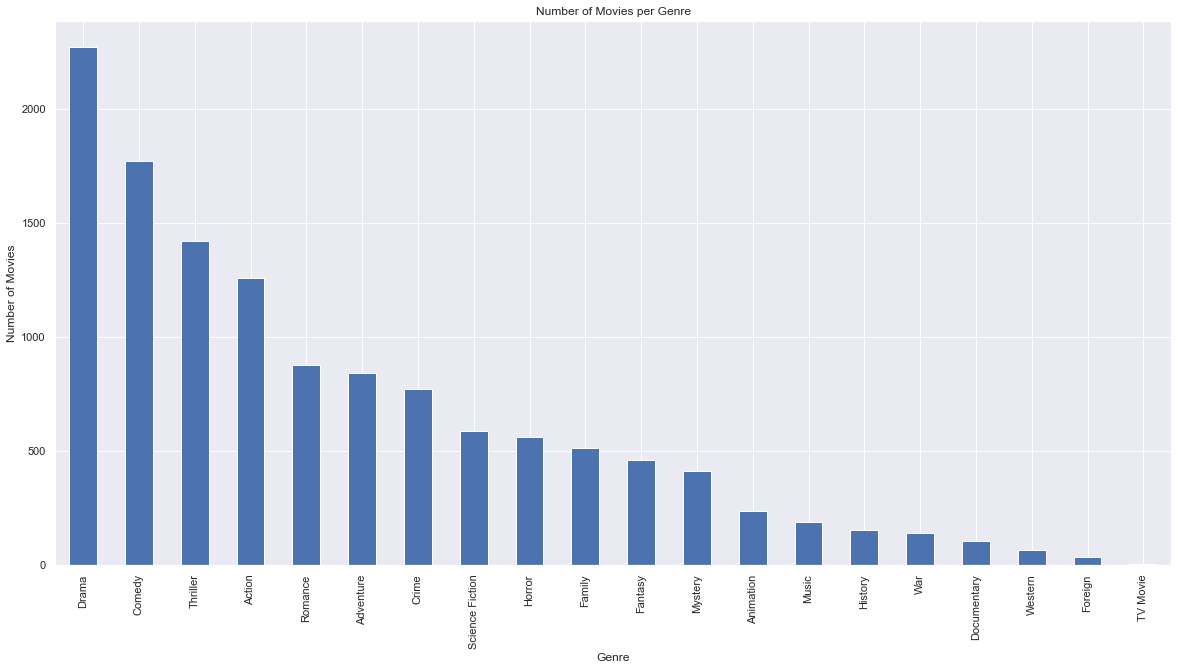

In [50]:
tmdb_movie_data_genre_df\
    .genres\
    .value_counts()\
    .plot(kind="bar", figsize=(20, 10));
plt.ylabel('Number of Movies');
plt.xlabel('Genre');
plt.title('Number of Movies per Genre');

Let's see if this picture is repeated throughout the years. We're going to use the same year axis for all plots.

In [51]:
year_idx = tmdb_movie_data_genre_df.release_year.sort_values().unique()

Let's plot the number of "drama" movies throughout the years:

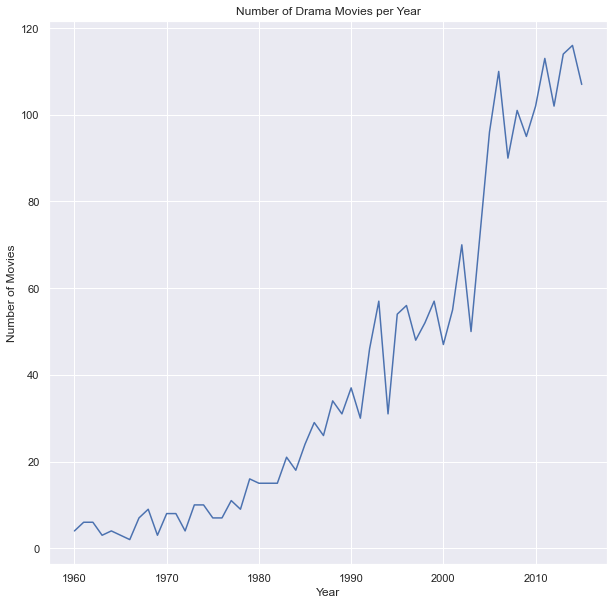

In [52]:
plt.figure(figsize=(10, 10))
plt.ylabel('Number of Movies');
plt.xlabel('Year');
plt.title('Number of Drama Movies per Year');
plt.plot(
    year_idx,                                                             # Index by year
    tmdb_movie_data_genre_df[tmdb_movie_data_genre_df.genres == "Drama"]  # Filter by genre
        .groupby("release_year")                                          # Group by release year
        .imdb_id.count()                                                  # Count on a column
        .reindex(year_idx).fillna(0));                                    # Fill missing values

Let's try the moving averages trick to smoothout the line:

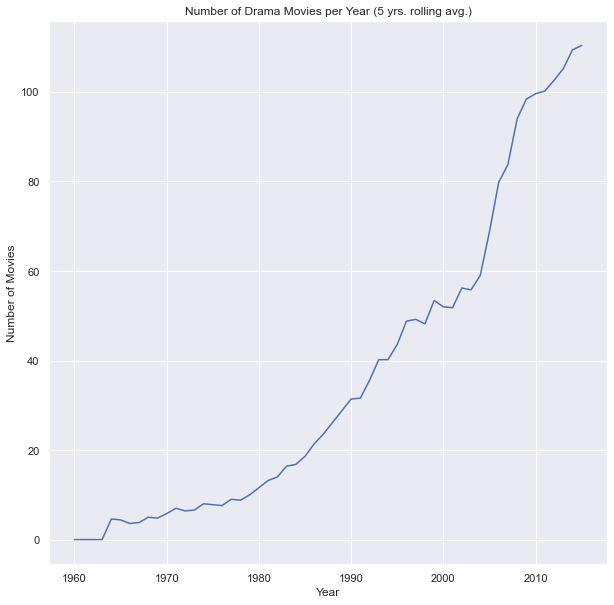

In [53]:
plt.figure(figsize=(10, 10))
plt.ylabel('Number of Movies');
plt.xlabel('Year');
plt.title('Number of Drama Movies per Year (5 yrs. rolling avg.)');
plt.plot(
    year_idx,                                                             # Index by year
    tmdb_movie_data_genre_df[tmdb_movie_data_genre_df.genres == "Drama"]  # Filter by genre
        .groupby("release_year")                                          # Group by release year
        .imdb_id.count()                                                  # Count on a column
        .rolling(5).mean()                                                # Rolling average
        .reindex(year_idx).fillna(0)                                      # Fill missing values
);

Now let's plot the progression of all genres:

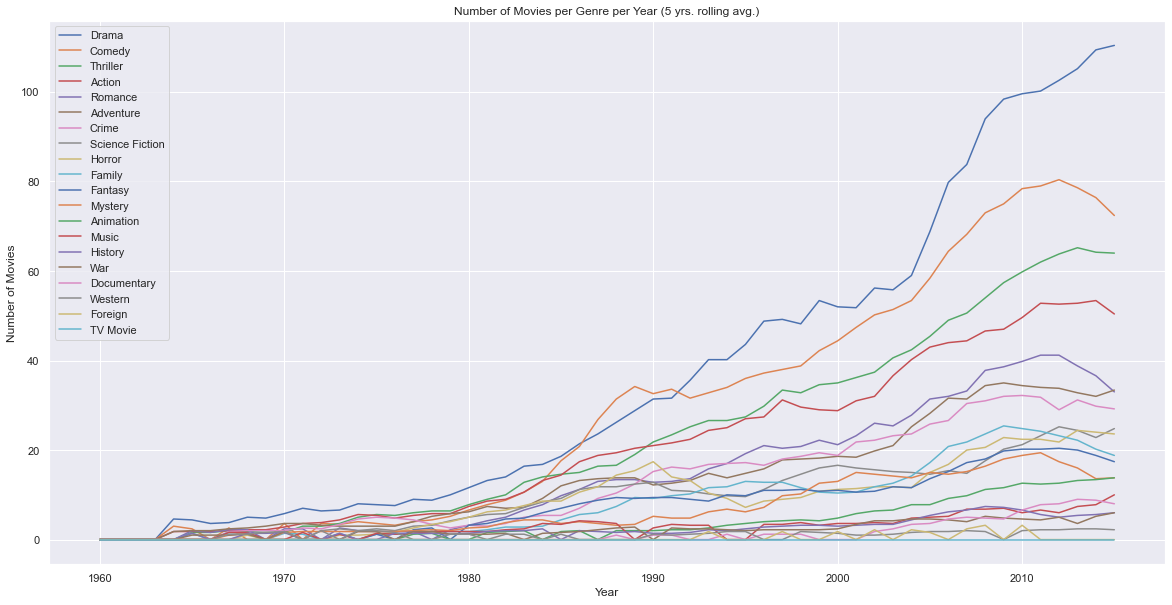

In [54]:
plt.figure(figsize=(20, 10))
plt.ylabel('Number of Movies');
plt.xlabel('Year');
plt.title('Number of Movies per Genre per Year (5 yrs. rolling avg.)');
for genre in tmdb_movie_data_genre_df.genres.value_counts().index.to_list():  # Iterate over genres
    plt.plot(
        year_idx,                                                             # Index by year
        tmdb_movie_data_genre_df[tmdb_movie_data_genre_df.genres == genre]    # Filter by genre
            .groupby("release_year")                                          # Group by release year
            .imdb_id.count()                                                  # Count on a column
            .rolling(5).mean()                                                # Rolling average
            .reindex(year_idx).fillna(0),                                     # Fill missing values
        label=genre);
plt.legend();

The chart is kinda hard to parse, let's pickly only the 5 top genres:

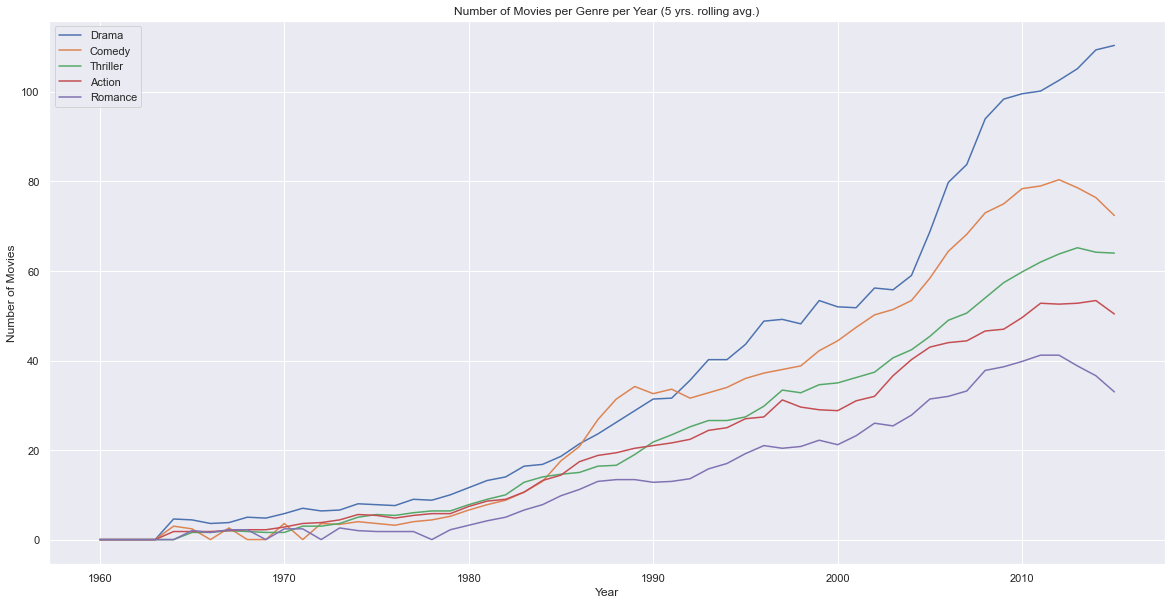

In [55]:
plt.figure(figsize=(20, 10))
plt.ylabel('Number of Movies');
plt.xlabel('Year');
plt.title('Number of Movies per Genre per Year (5 yrs. rolling avg.)');
for genre in tmdb_movie_data_genre_df.genres.value_counts().index.to_list()[:5]:  # Iterate over genres (slice top 5)
    plt.plot(
        year_idx, 
        tmdb_movie_data_genre_df[tmdb_movie_data_genre_df.genres == genre]\
            .groupby("release_year")\
            .imdb_id.count()\
            .rolling(5).mean()\
            .reindex(year_idx).fillna(0),
        label=genre);
plt.legend();

As we can see, drama movies were indeed always popular, but they were briefly surpassed by comedies in the late 90s.

### What kinds of properties are associated with movies that have high revenues?

#### Does a higher budget lead to more revenue?

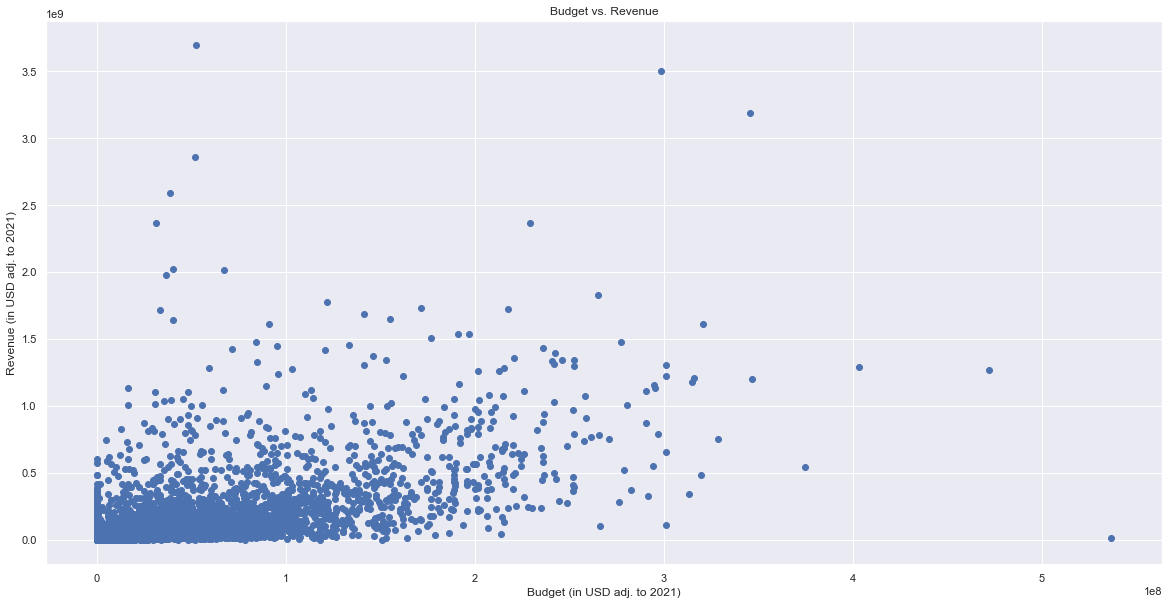

In [56]:
plt.figure(figsize=(20, 10))
plt.ylabel('Revenue (in USD adj. to 2021)');
plt.xlabel('Budget (in USD adj. to 2021)');
plt.title('Budget vs. Revenue');
plt.scatter(
    tmdb_movie_data_df.budget_adj_2021,   # 2021 Adjusted budget vs.
    tmdb_movie_data_df.revenue_adj_2021,  # 2021 Adjusted revenue
);

I can't really conclude from the chart that a higher revenue does imply a higher revenue. Let's compute the correlation factor:

In [57]:
tmdb_movie_data_df.budget_adj_2021.corr(tmdb_movie_data_df.revenue_adj_2021)

0.5877953736810668

This would imply that there is indeed a correlation between the two variables.

#### Are highly rated movies good performers?

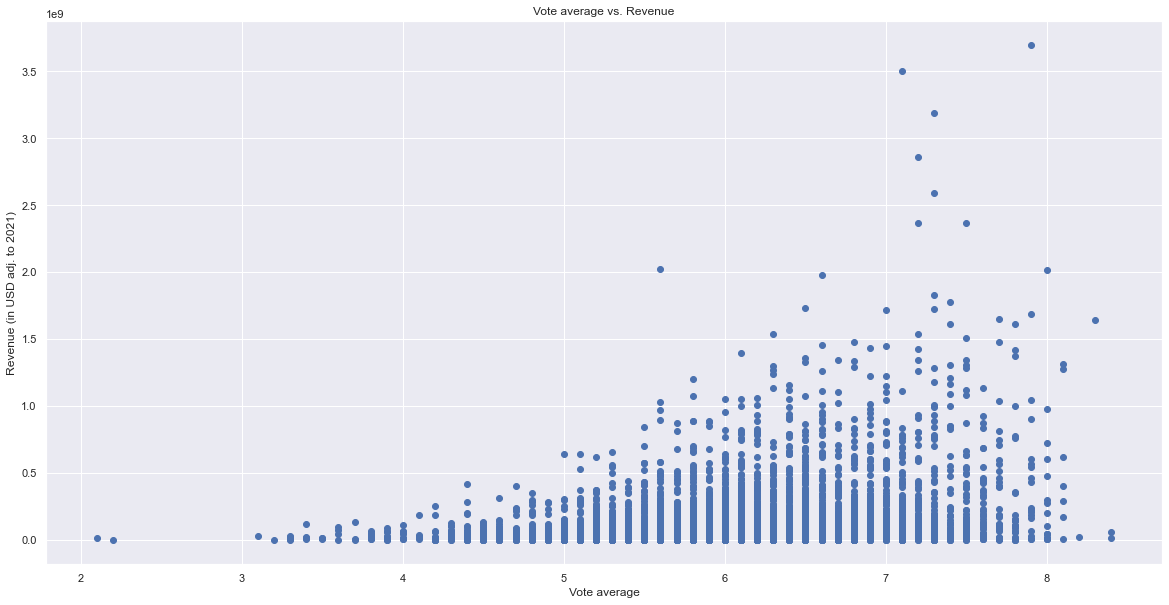

In [58]:
plt.figure(figsize=(20, 10))
plt.ylabel('Revenue (in USD adj. to 2021)');
plt.xlabel('Vote average');
plt.title('Vote average vs. Revenue');
plt.scatter(
    tmdb_movie_data_df.vote_average,      # Vote average
    tmdb_movie_data_df.revenue_adj_2021,  # 2021 Adjusted revenue
);

In [59]:
tmdb_movie_data_df.vote_average.corr(tmdb_movie_data_df.revenue_adj_2021)

0.24293287516604284

Both the chart and the correlation factor show there's no strong correlation between the variables.

#### Does the running time influence the revenue?

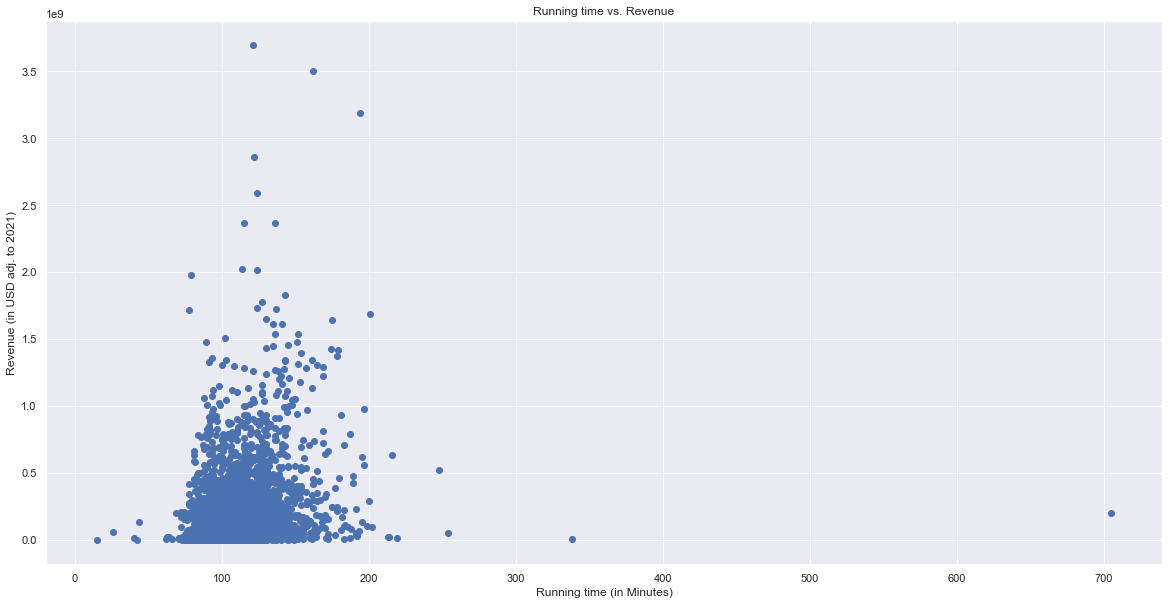

In [60]:
plt.figure(figsize=(20, 10))
plt.ylabel('Revenue (in USD adj. to 2021)');
plt.xlabel('Running time (in Minutes)');
plt.title('Running time vs. Revenue');
plt.scatter(
    tmdb_movie_data_df.runtime,           # Running time
    tmdb_movie_data_df.revenue_adj_2021,  # 2021 Adjusted revenue
);

It's hard to take any conclusions of the chart as most samples are bunched around the 120 minute mark, and there are a few outliers.

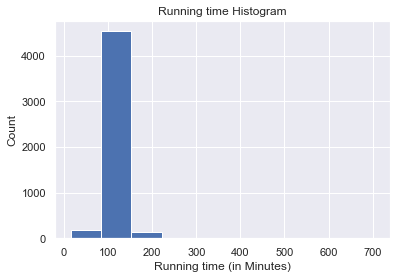

In [61]:
tmdb_movie_data_df.runtime.hist();
plt.ylabel('Count');
plt.xlabel('Running time (in Minutes)');
plt.title('Running time Histogram');

I don't know if this distribution would allow me to extract any valuable information out of it.

In [62]:
tmdb_movie_data_df.runtime.corr(tmdb_movie_data_df.revenue_adj_2021)

0.2632592523685177

Again, not a strong correlation between the two.

#### Does the genre play a role on the revenue?

Let's take the 5 most popular genres and see if any one of them consistently outperform the others in terms of revenue.

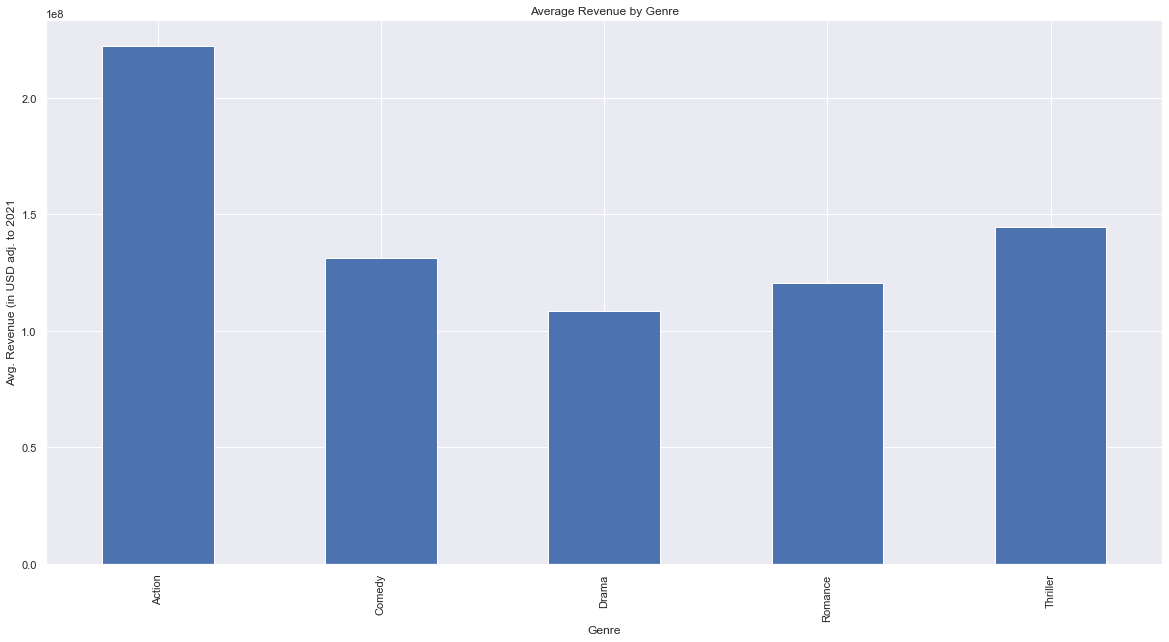

In [63]:
tmdb_movie_data_genre_df[tmdb_movie_data_genre_df.genres.isin(
    tmdb_movie_data_genre_df.genres.value_counts().index.to_list()[:5]
)].groupby("genres").revenue_adj_2021.mean().plot(kind="bar", figsize=(20, 10));
plt.ylabel("Avg. Revenue (in USD adj. to 2021");
plt.xlabel("Genre");
plt.title("Average Revenue by Genre");

Quite unsurprisingly action movies outperformed all the other genres, but was it always the case?

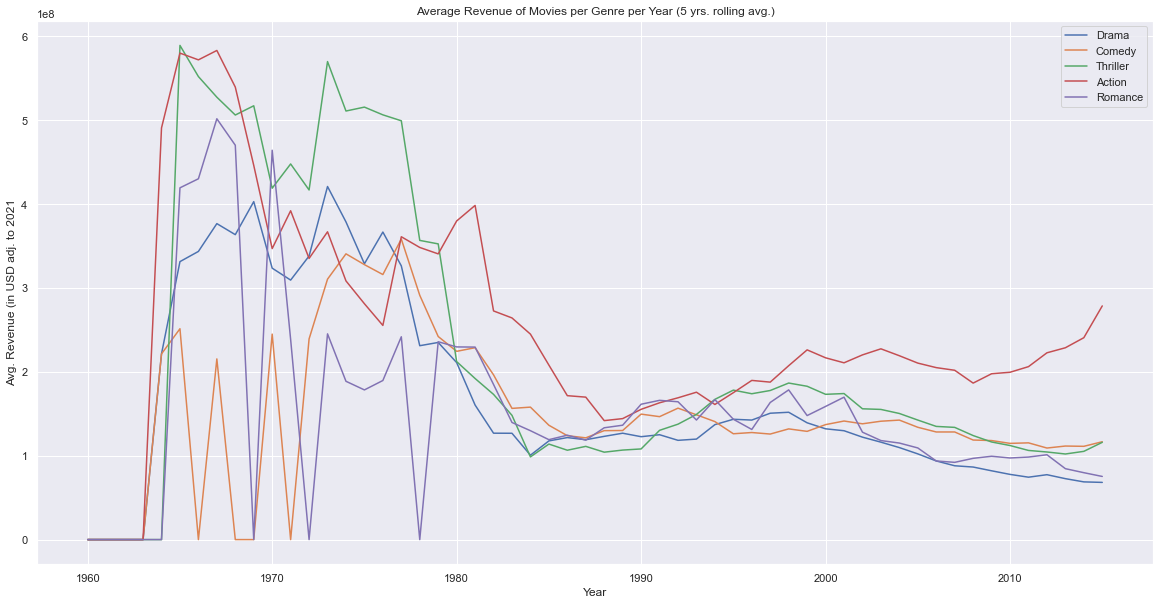

In [64]:
plt.figure(figsize=(20, 10))
plt.ylabel("Avg. Revenue (in USD adj. to 2021");
plt.xlabel('Year');
plt.title('Average Revenue of Movies per Genre per Year (5 yrs. rolling avg.)');
for genre in tmdb_movie_data_genre_df.genres.value_counts().index.to_list()[:5]:    # Iterate over genres (slice top 5)
    plt.plot(
        year_idx,                                                           # Index by year
        tmdb_movie_data_genre_df[tmdb_movie_data_genre_df.genres == genre]  # Filter by genre       
            .groupby("release_year")                                        # Group by release year
            .revenue_adj_2021.mean()                                        # Take the mean revenue
            .rolling(5).mean()                                              # Rolling average
            .reindex(year_idx).fillna(0),                                   # Fill missing values
        label=genre);
plt.legend();

It's no clear to see, but during the 70s, thrillers outperformed action films, so a specific genre is not a recipe for success.

### Is there a specific month of the year were the highest grossing films released? Is this consistent across genres?

Let's see how films are usually released throughout the year. First we create a new column with the release month:

In [65]:
tmdb_movie_data_df["release_month"] = tmdb_movie_data_df.release_date.dt.month_name()

Then we plot the amount of movies released on each month:

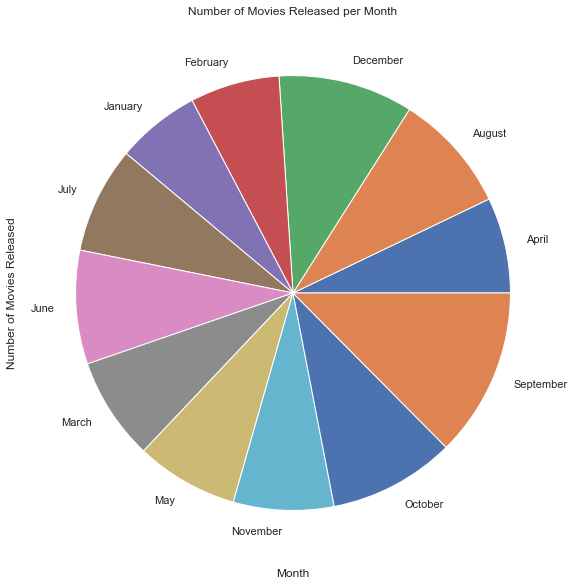

In [66]:
tmdb_movie_data_df\
    .groupby("release_month")\
    .imdb_id.count()\
    .plot(kind="pie", figsize=(20, 10));
plt.ylabel("Number of Movies Released");
plt.xlabel("Month");
plt.title("Number of Movies Released per Month");

As we can see, the releases a pretty evenly distributed throughout the year. Are there any specific months were the highest grosing films are released?

In [67]:
tmdb_movie_data_df.groupby("release_month").revenue_adj_2021.mean()

release_month
April        1.171574e+08
August       9.662204e+07
December     2.206492e+08
February     9.275970e+07
January      7.403427e+07
July         1.953627e+08
June         2.526292e+08
March        1.402465e+08
May          2.130237e+08
November     2.067638e+08
October      1.075877e+08
September    6.475442e+07
Name: revenue_adj_2021, dtype: float64

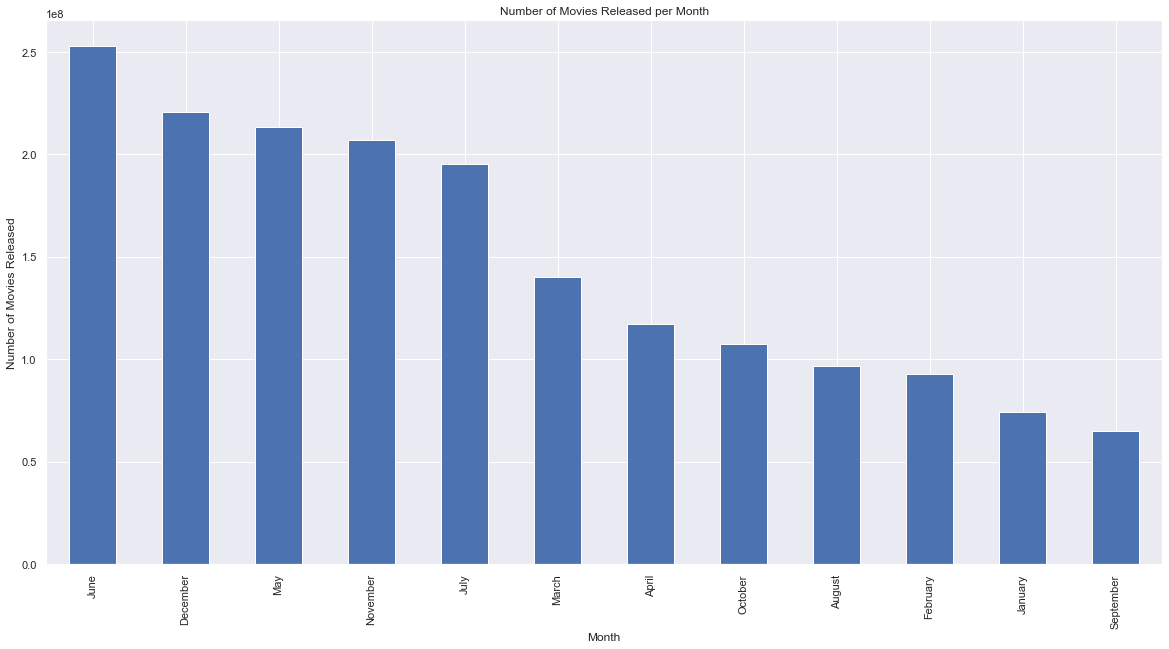

In [68]:
tmdb_movie_data_df\
    .groupby("release_month")\
    .revenue_adj_2021.mean()\
    .sort_values(ascending=False)\
    .plot(kind="bar", figsize=(20, 10));
plt.ylabel("Number of Movies Released");
plt.xlabel("Month");
plt.title("Number of Movies Released per Month");

It would seem that May, June, July (beginning of summer), November and December (holiday season) are were the highest grossing films are released. Was it always like this?

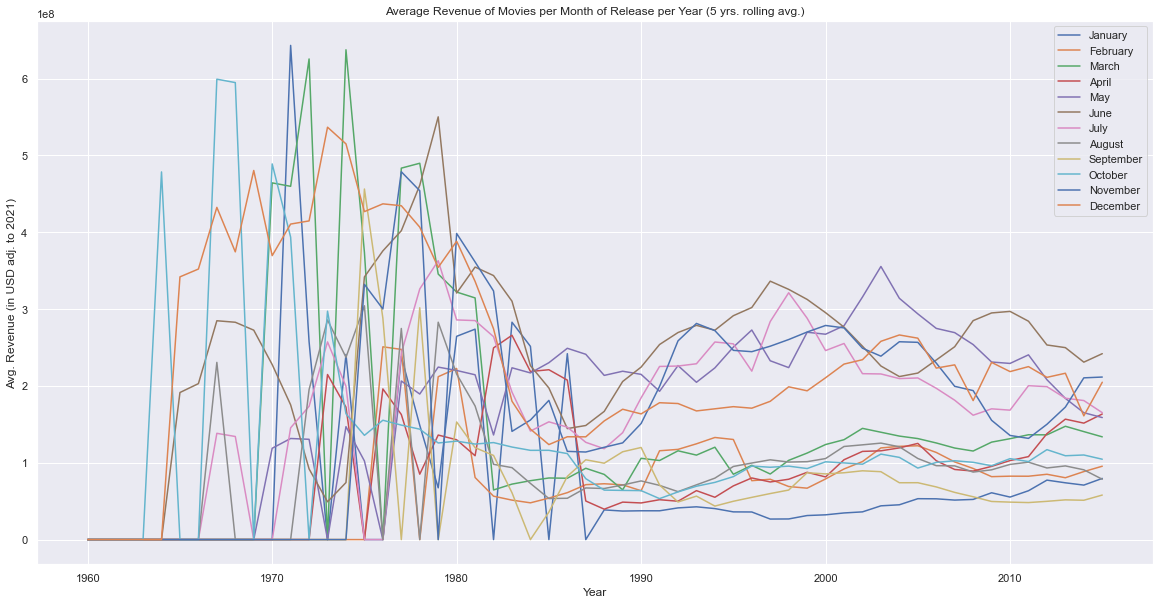

In [69]:
plt.figure(figsize=(20, 10))
plt.ylabel("Avg. Revenue (in USD adj. to 2021)");
plt.xlabel('Year');
plt.title('Average Revenue of Movies per Month of Release per Year (5 yrs. rolling avg.)');
for month in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
    plt.plot(
        year_idx,                                                      # Index by year
        tmdb_movie_data_df[tmdb_movie_data_df.release_month == month]  # Filter by release month
            .groupby("release_year")                                   # Group by release year
            .revenue_adj_2021.mean()                                   # Revenue mean
            .rolling(5).mean()                                         # Rolling average
            .reindex(year_idx).fillna(0),                              # Fill missing values
        label=month);
plt.legend();

It would seem that the monthly distribution changed over the years, but the tendencies have endured.

### Of the top 5 most prolific directors, which one had the most consistently highly rated films?

First, let's look which are the most prolific directors.

In [70]:
tmdb_movie_data_director_df = tmdb_movie_data_df.explode("director")

In [71]:
tmdb_movie_data_director_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,adj_factor_2021,budget_adj_2021,revenue_adj_2021,release_month
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.144606,1.716910e+08,1.732395e+09,June
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,1.144606,1.716910e+08,4.331607e+08,May
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.144606,1.259067e+08,3.379316e+08,March
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.144606,2.289213e+08,2.367250e+09,December
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09,1.144606,2.174752e+08,1.724063e+09,April


Let's use ``Series.value_counts`` to get the directos with the most rows:

In [72]:
tmdb_movie_data_director_df\
    .director\
    .value_counts()\
    .iloc[:5]

Steven Spielberg    28
Clint Eastwood      26
Ridley Scott        22
Woody Allen         22
Ron Howard          18
Name: director, dtype: int64

Now let's see how their movies perform in terms of popularity, vote average, and revenue.

In [73]:
top_5_directors = tmdb_movie_data_director_df.director.value_counts().iloc[:5].index.values

In [74]:
tmdb_movie_data_director_df[tmdb_movie_data_director_df.director.isin(top_5_directors)]\
    .groupby("director")[["popularity", "vote_average", "revenue_adj_2021"]]\
    .describe()

popularity                                                    \
                      count      mean       std       min       25%       50%   
director                                                                        
Clint Eastwood         26.0  0.956933  0.732361  0.245162  0.597541  0.733779   
Ridley Scott           22.0  2.082423  1.927945  0.320540  0.654909  1.519517   
Ron Howard             18.0  1.446277  1.037013  0.309976  0.643578  0.991402   
Steven Spielberg       28.0  1.920691  1.170379  0.210550  0.976488  2.136865   
Woody Allen            22.0  0.678411  0.327162  0.133990  0.418351  0.665965   

                                     vote_average            ...              \
                       75%       max        count      mean  ...    75%  max   
director                                                     ...               
Clint Eastwood    1.088227  3.863074         26.0  6.626923  ...  7.050  7.6   
Ridley Scott      3.389883  7.667400         22.0  6.504545  ...  7.075  7.7   
Ron Howard        2.186163  3.655536         18.0  6.466667  ...  6.650  7.7   
Steven Spielberg  2.647532  4.578300         28.0  6.785714  ...  7.325  8.1   
Woody Allen       0.917104  1.367727         22.0  6.686364  ...  7.075  7.7   

                 revenue_adj_2021                                            \
                            count          mean           std           min   
director                                                                      
Clint Eastwood               26.0  1.803024e+08  1.301395e+08  4.009381e+07   
Ridley Scott                 22.0  2.457544e+08  2.235089e+08  1.430816e+07   
Ron Howard                   18.0  3.217733e+08  2.609226e+08  6.263389e+07   
Steven Spielberg             28.0  7.113975e+08  6.628754e+08  7.811741e+07   
Woody Allen                  22.0  7.638031e+07  5.780522e+07  5.673579e+06   

                                                                          
                           25%           50%           75%           max  
director                                                                  
Clint Eastwood    9.239935e+07  1.402861e+08  2.298461e+08  6.307982e+08  
Ridley Scott      8.336332e+07  1.265985e+08  3.838344e+08  7.444497e+08  
Ron Howard        1.146848e+08  2.483344e+08  4.822413e+08  1.052068e+09  
Steven Spielberg  2.122616e+08  5.005232e+08  9.364727e+08  2.586439e+09  
Woody Allen       3.002775e+07  4.282607e+07  1.201418e+08  1.877904e+08  

[5 rows x 24 columns]

Which one of this directors has the most popular movie?

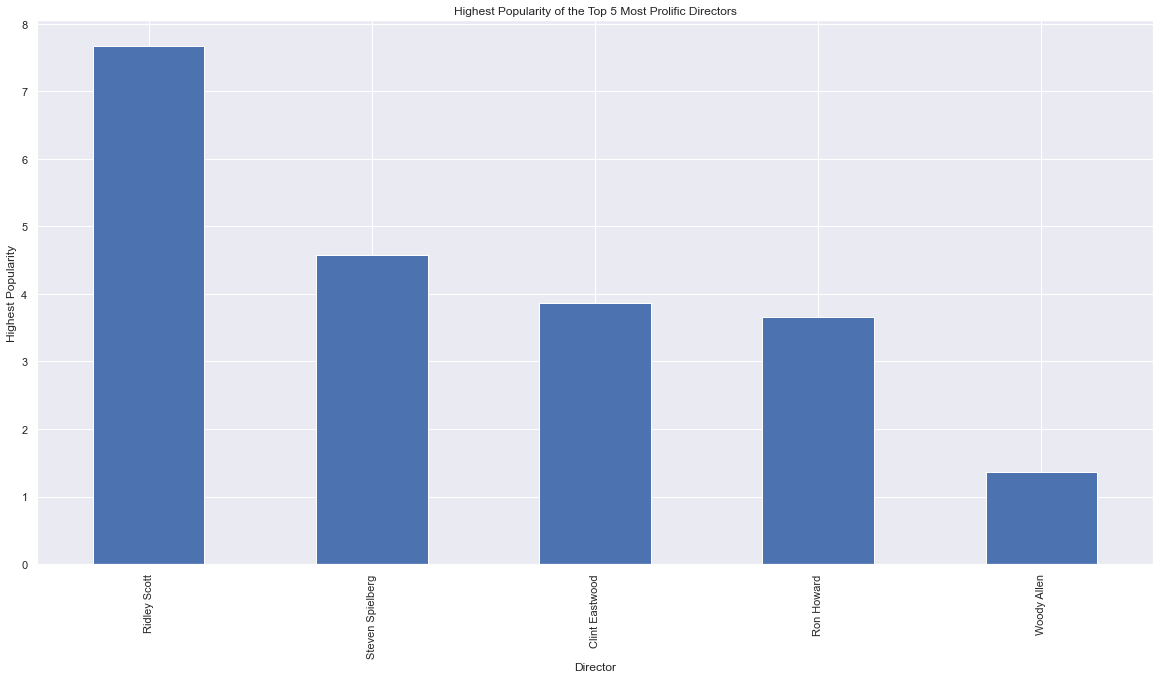

In [75]:
tmdb_movie_data_director_df[tmdb_movie_data_director_df.director.isin(top_5_directors)]\
    .groupby("director")\
    .popularity.max()\
    .sort_values(ascending=False)\
    .plot(kind="bar", figsize=(20, 10));
plt.ylabel("Highest Popularity");
plt.xlabel("Director");
plt.title("Highest Popularity of the Top 5 Most Prolific Directors");

Is Ridley Scott also the highest grossing of the bunch?

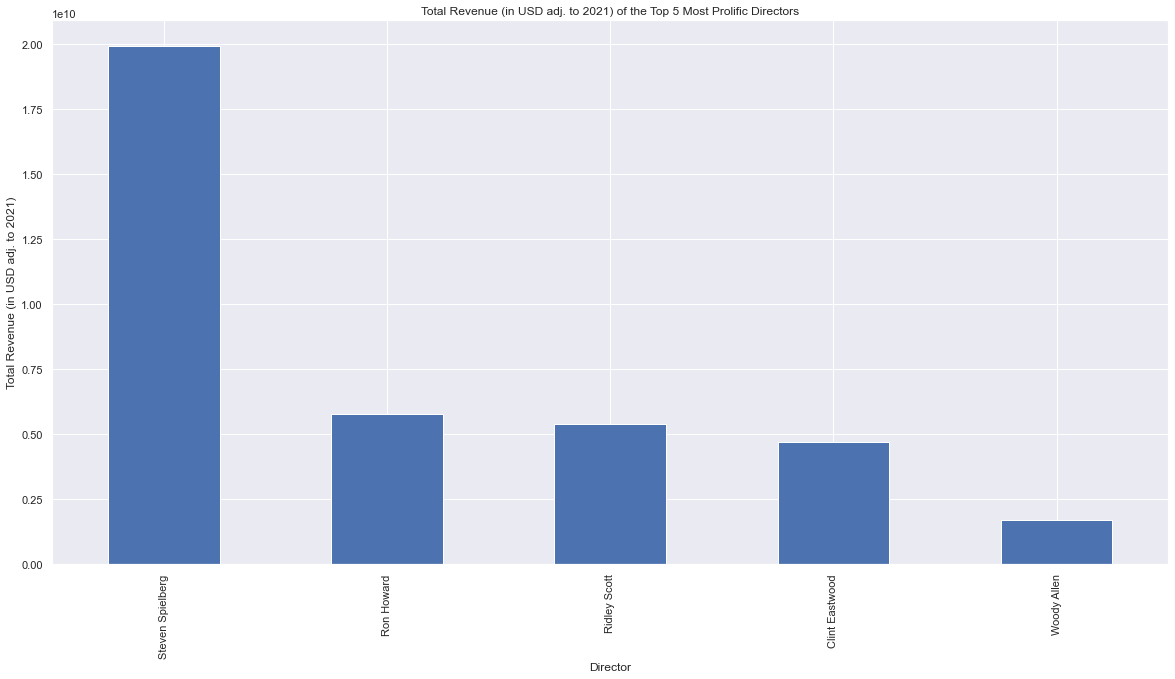

In [76]:
tmdb_movie_data_director_df[tmdb_movie_data_director_df.director.isin(top_5_directors)]\
    .groupby("director")\
    .revenue_adj_2021.sum()\
    .sort_values(ascending=False)\
    .plot(kind="bar", figsize=(20, 10));
plt.ylabel("Total Revenue (in USD adj. to 2021)");
plt.xlabel("Director");
plt.title("Total Revenue (in USD adj. to 2021) of the Top 5 Most Prolific Directors");

Unsurprising, given that Steven Spielberg is the most prolific of the bunch. But how has Spielberg's work evolved over the years?

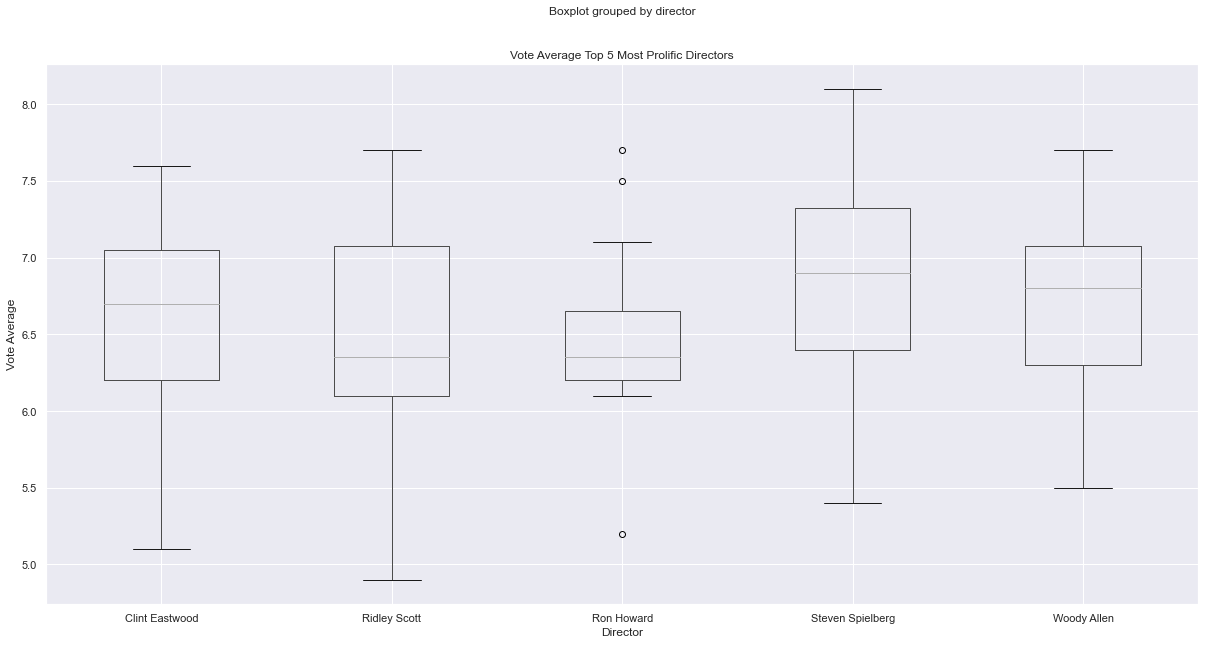

In [77]:
tmdb_movie_data_director_df[tmdb_movie_data_director_df.director.isin(top_5_directors)]\
    .boxplot("vote_average", by="director", figsize=(20, 10));
plt.ylabel("Vote Average");
plt.xlabel("Director");
plt.title("Vote Average Top 5 Most Prolific Directors");

It's pretty clear from the chart that Steven Spielberg is consistently well rated.

<a id='conclusions'></a>
## Conclusions

### Which genres are most popular from year to year?

Before any work was done I had to make an assumption of what "popularity" means. We do have a ``popularity`` column, but given that it is a synthetic variable computed from multiple sources it would be hard to reach any conclusions about it. Because of this, I chose the number of movies made as a measure of popularity of the genre.

With this in mind, the charts showed somewhat clearly (after smoothing them out) that Drama is a consistent winner in terms of popularity, followed by Comedy and Thriller. Moreover, with only a few exceptions, this situation remained the same througout the years.

### What kinds of properties are associated with movies that have high revenues?

I've tried a explored a few variables that might lead to a higher revenue value, but other than a higher budget and genre (Action in particular) seem to imply a higher revenue (no surprises here).

I thought a higher vote rating would lead to higher revenues, but the correlation was weak, same as with the runtime.

### Is there a specific month of the year were the highest grossing films released? Is this consistent across genres?

Although this question could have been answered in the context of the previous one, I wanted to focus on the release month specifically to do a more in depth analysis.

The conclusion of this analysis is that movies released in the summer and holiday seasons seem to do better than those released throughout the year. Perhaps people have more time to go to the movies during these seasons, or maybe studios specifically wait until these times to release movies that they expect to be the highest grossing ones.

### Of the top 5 most prolific directors, which one had the most consistently highly rated films?

The main conclusion here is that Steven Spielberg is a movie making machine. He's incredibly prolific, and his seem to be financial and critical successes.

### Limitations

All of these conclusions are to be taken with a grain of salt as there a quite a few limitations with the dataset:

* There's not much metadata about the dataset. The kaggle page does not provide (AFAIK) explicit descriptions of each column. The TMDb website does contain documentation about their APIs, but it's not clear what was done by Kaggle to curate it. 
* There's not much data available, specially for the earlier years. This makes any time-based analysis inaccurate for certain periods. This is is clearly shown in the charts over time.
* There's no actual viewership numbers that would lead to a more accurate popularity variable. I could have inferred this from the vote count, but that was an assumption I was not willing to make.